In [644]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.stats import skew
import scipy.stats as stats
import statsmodels.api as sm
import numpy as np

df = pd.read_csv('microwage.csv')

Occupation Encoding

In [645]:
occu = ['occ_managprof', 'occ_techsalad', 'occ_service', 'occ_farm', 'occ_product',	'occ_operator',	'occ_service_np', 'occ_service_broad']

df['occupation'] = df[occu].idxmax(axis=1)
df = df.drop(columns=occu)

occu_encodings = {col : occu.index(col) for col in occu}
df['occupation'] = df['occupation'].replace(occu_encodings)

occu_encodings = {col : occu.index(col) for col in occu}
df['occupation'] = df['occupation'].replace(occu_encodings)

/var/folders/6g/4zq1d985075_7_l6gxj2n81m0000gn/T/ipykernel_1253/762704718.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['occupation'] = df['occupation'].replace(occu_encodings)


Removing Outliers

In [646]:
cols = ['edyrs', 'puma']

for col in cols:
    quartiles = df[col].quantile([0.25, 0.75])
    q1 = quartiles.loc[0.25]
    q3 = quartiles.loc[0.75]

    low_bound = q1 - 1.5 * (q3 - q1)
    upp_bound = q3 + 1.5 * (q3 - q1)

    df = df[(df[col] >= low_bound) & (df[col] <= upp_bound)]

Correlation Visualization

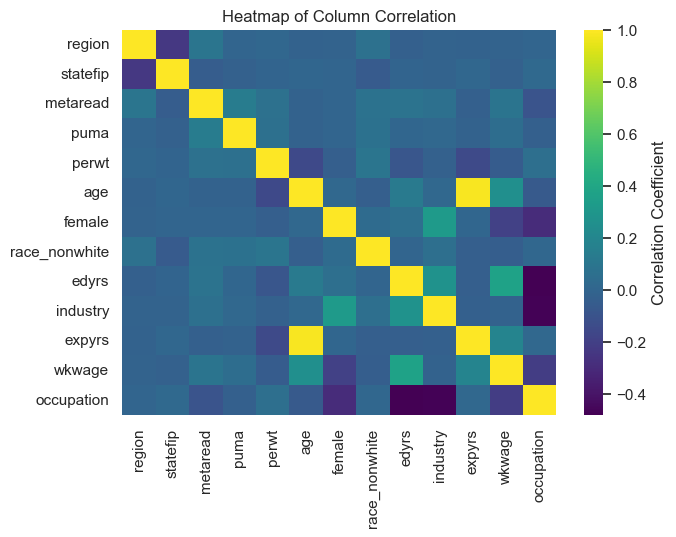

In [647]:
sns.set_theme(rc = {'figure.figsize':(7, 5)})
sns.heatmap(df.corr(), cmap='viridis', fmt='.2f', cbar_kws={'label': 'Correlation Coefficient'})
plt.title('Heatmap of Column Correlation')
plt.show()

Removing Variables

In [648]:
df = df.drop(columns=['region', 'statefip', 'race_nonwhite', 'perwt'])

Handling Skewness

In [649]:
skewed_columns = df.apply(lambda x: skew(x))

print("Before Handling Skewness")
print(skewed_columns)

skewed_columns = skewed_columns[(skewed_columns > 0.5) | (skewed_columns > -0.5)]

for col in skewed_columns.index:
    df[col] = np.log1p(df[col])

print("\nAfter Handling Skewness")
print(df.apply(lambda x: skew(x)))

Before Handling Skewness
metaread      0.355840
puma          0.820806
age          -0.062562
female       -0.002552
edyrs        -0.075731
industry     -0.887840
expyrs        0.020558
wkwage        3.352535
occupation    0.936999
dtype: float64

After Handling Skewness
metaread     -0.952649
puma         -0.825825
age          -0.528159
female       -0.002552
edyrs        -0.657159
industry     -0.887840
expyrs       -1.262564
wkwage       -0.544092
occupation    0.230689
dtype: float64


Handling Non-linearity

In [650]:
cols = ['edyrs', 'puma']

for col in cols:
    df[col] = np.log(df[col])


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Model 1

In [651]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

X = df
X = X.drop(columns=['wkwage'])
y = df[['wkwage']]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()

model.fit(X_train, y_train)

predictions = model.predict(X_test)

mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, predictions)

print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("R-squared (R²):", r2)

ValueError: Input X contains infinity or a value too large for dtype('float64').

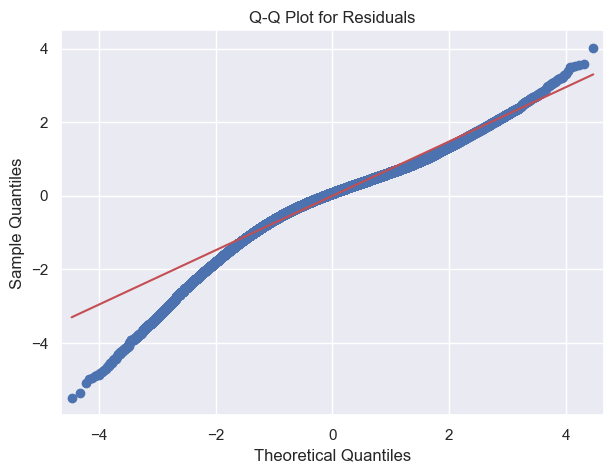

In [ ]:
residuals = y_test['wkwage'] - predictions.reshape(-1)

sm.qqplot(residuals, line='s')  # 's' denotes a standardized line
plt.title('Q-Q Plot for Residuals')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Sample Quantiles')
plt.grid(True)
plt.show()

Model 2

In [ ]:
import statsmodels.api as sm

# Add a constant term for the intercept
X_train = sm.add_constant(X_train)

# Fit the OLS model
ols_model = sm.OLS(y_train, X_train).fit()

# Print the summary of the model
print(ols_model.summary())

                            OLS Regression Results                            
Dep. Variable:                 wkwage   R-squared:                       0.385
Model:                            OLS   Adj. R-squared:                  0.385
Method:                 Least Squares   F-statistic:                 8.143e+04
Date:                Tue, 19 Mar 2024   Prob (F-statistic):               0.00
Time:                        00:19:24   Log-Likelihood:            -1.1611e+06
No. Observations:             1041341   AIC:                         2.322e+06
Df Residuals:                 1041332   BIC:                         2.322e+06
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.0057      0.031    130.169      0.0

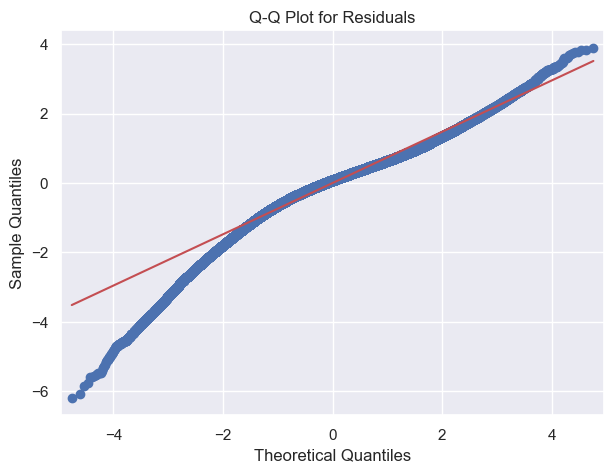

In [ ]:
import statsmodels.api as sm

residuals = ols_model.resid

# Create a Q-Q plot for the residuals
sm.qqplot(residuals, line='s')  # 's' denotes a standardized line
plt.title('Q-Q Plot for Residuals')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Sample Quantiles')
plt.grid(True)
plt.show()